In [1]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages
library(lubridate)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.4     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




In [2]:
list.files(path = "../input/new-york-city-corporate-loans")

[1] "NYC_Loans.csv"

In [3]:
# read the data
df<- read_csv("/kaggle/input/new-york-city-corporate-loans/NYC_Loans.csv", na=c("",NA))
dim(df)


── Column specification ────────────────────────────────────────────────────────
cols(
  `Authority Name` = col_character(),
  `Fiscal Year End Date` = col_character(),
  Loans = col_character(),
  `Loan Fund Sources` = col_character(),
  `Recipient Name` = col_character(),
  `Recipient City` = col_character(),
  `Recipient State` = col_character(),
  `Recipient Postal Code` = col_double(),
  `Date Loan Awarded` = col_character(),
  `Original Loan Amount` = col_double(),
  `Interest Rate` = col_double(),
  `Loan Length` = col_double(),
  `Amount Repaid` = col_double(),
  `Loan Purpose` = col_character(),
  `New Jobs` = col_character(),
  `Jobs Planned` = col_double(),
  `Jobs Created` = col_double(),
  `Loan Terms Completed` = col_character()
)


Warning message:
“1 parsing failure.
  row                   col expected  actual                                                        file
12720 Recipient Postal Code a double NRR 5S7 '/kaggle/input/new-york-city-corporate-loans/NYC_Loans.

[1] 13513    18

In [4]:
# check for missing data
sum(is.na(df))
colSums(is.na(df))

[1] 47625

Authority Name  Fiscal Year End Date                 Loans 
                    0                     0                 11973 
    Loan Fund Sources        Recipient Name        Recipient City 
                 1540                  1540                  1540 
      Recipient State Recipient Postal Code     Date Loan Awarded 
                 1541                  1541                  1540 
 Original Loan Amount         Interest Rate           Loan Length 
                 1540                  1540                  1540 
        Amount Repaid          Loan Purpose              New Jobs 
                 1540                  1540                  1540 
         Jobs Planned          Jobs Created  Loan Terms Completed 
                 7802                  7828                  1540

As we can see a majority of columns/variables have missing values. 
Since I did not collect the data and the given data dictionary is incomplete, I'll take the liberty of removing the missing data from further analysis.
But first, I'll prepare the data to follow the [tidy data principles](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html)

In [5]:
# Data cleaning

# lowercase variable name & rename them
colnames(df)<- tolower(colnames(df))
# rename columns by replacing space with dot
df <- df %>%
  rename_all(list(~make.names(.)))
colnames(df)

[1] "authority.name"        "fiscal.year.end.date"  "loans"                
 [4] "loan.fund.sources"     "recipient.name"        "recipient.city"       
 [7] "recipient.state"       "recipient.postal.code" "date.loan.awarded"    
[10] "original.loan.amount"  "interest.rate"         "loan.length"          
[13] "amount.repaid"         "loan.purpose"          "new.jobs"             
[16] "jobs.planned"          "jobs.created"          "loan.terms.completed"

In [6]:
# split date into day, month, year cols
str(df)

df<-df %>%
  mutate(
    fisclYrEndDate = mdy(fiscal.year.end.date),
    fsYrEnd_month = month(fisclYrEndDate),
    fsYrEnd_day = day(fisclYrEndDate),
    fsYrEnd_year = year(fisclYrEndDate)
    )

df<-df %>%
  mutate(loan_award_date = mdy(date.loan.awarded),
         loanaward_month = month(loan_award_date),
         loanaward_day = day(loan_award_date),
         loanaward_year = year(loan_award_date)
         )
# change month number to month name
df$loanaward_month<- month.name[df$loanaward_month]
df$fsYrEnd_month<- month.name[df$fsYrEnd_month]

# drop column
df$loan_award_date<- NULL
df$date.loan.awarded<- NULL
df$fiscal.year.end.date<- NULL
df$fisclYrEndDate<- NULL
df$fiscal.year.end.date<- NULL
# drop loans column because it has only 1 value "No" and rest values are blank
df$loans<-NULL
str(df)

spec_tbl_df [13,513 × 18] (S3: spec_tbl_df/tbl_df/tbl/data.frame)
 $ authority.name       : chr [1:13513] "Columbia County Capital Resource Corporation" "Monroe County Sports Development Corporation" "Riverhead IDA Economic Job Development Corporation" "Greene Tobacco Asset Securitization Corporation" ...
 $ fiscal.year.end.date : chr [1:13513] "12/31/2011" "12/31/2011" "12/31/2011" "12/31/2011" ...
 $ loans                : chr [1:13513] "No" "No" "No" "No" ...
 $ loan.fund.sources    : chr [1:13513] NA NA NA NA ...
 $ recipient.name       : chr [1:13513] NA NA NA NA ...
 $ recipient.city       : chr [1:13513] NA NA NA NA ...
 $ recipient.state      : chr [1:13513] NA NA NA NA ...
 $ recipient.postal.code: num [1:13513] NA NA NA NA NA NA NA NA NA NA ...
 $ date.loan.awarded    : chr [1:13513] NA NA NA NA ...
 $ original.loan.amount : num [1:13513] NA NA NA NA NA NA NA NA NA NA ...
 $ interest.rate        : num [1:13513] NA NA NA NA NA NA NA NA NA NA ...
 $ loan.length          : num [

#### Now, I'll filter out all missing data....

In [7]:
# filter columns with missing data
df<- df %>%
  filter(!is.na(df[,c(2:21)])) 
df<- df %>%
  filter(!is.na(df[, c(5:6)]))
df<- df %>%
  filter(!is.na(df[,c(13:14)]))
df<- df %>%
  filter(!is.na(df[,c(14)]))
colSums(is.na(df))
dim(df) # 5684 observations in 17 cols

authority.name     loan.fund.sources        recipient.name 
                    0                     0                     0 
       recipient.city       recipient.state recipient.postal.code 
                    0                     0                     0 
 original.loan.amount         interest.rate           loan.length 
                    0                     0                     0 
        amount.repaid          loan.purpose              new.jobs 
                    0                     0                     0 
         jobs.planned          jobs.created  loan.terms.completed 
                    0                     0                     0 
        fsYrEnd_month           fsYrEnd_day          fsYrEnd_year 
                    0                     0                     0 
      loanaward_month         loanaward_day        loanaward_year 
                    0                     0                     0

[1] 5684   21

Now let's look at univariate, bivariate visualisations to determine variable relationship's, distributions etc.

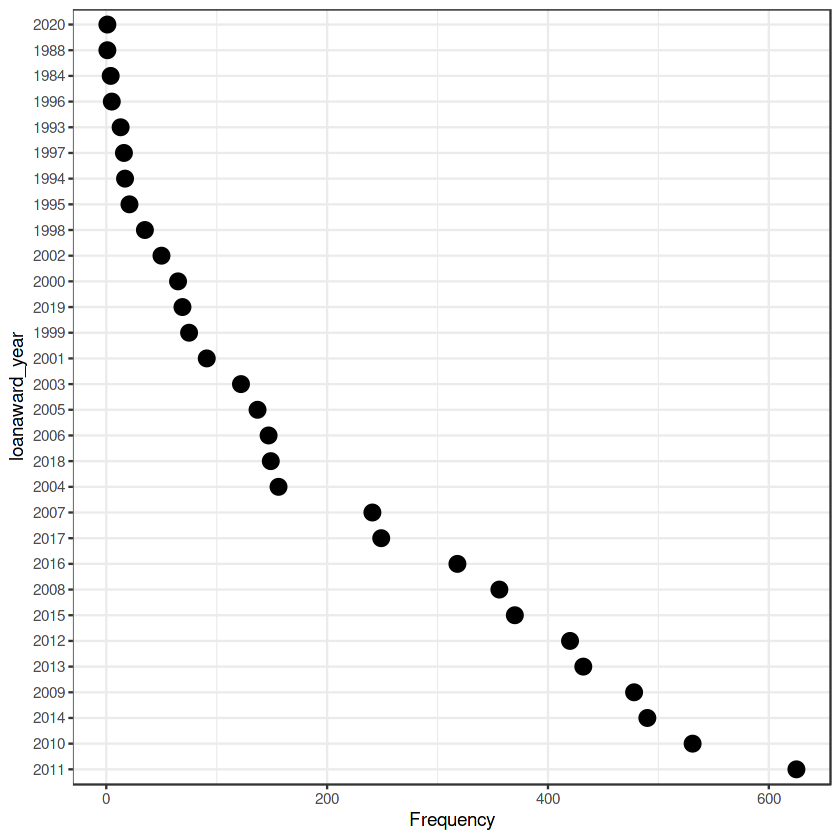

In [8]:
df %>%
  group_by(loanaward_year) %>%
  summarise(cnt = n()) %>%
  arrange(cnt) %>%
  ggplot(aes(reorder(x= loanaward_year, -cnt, FUN=min), cnt))+
  geom_point(size=4)+
  labs(x="loanaward_year", y="Frequency")+
  coord_flip()+
  theme_bw()

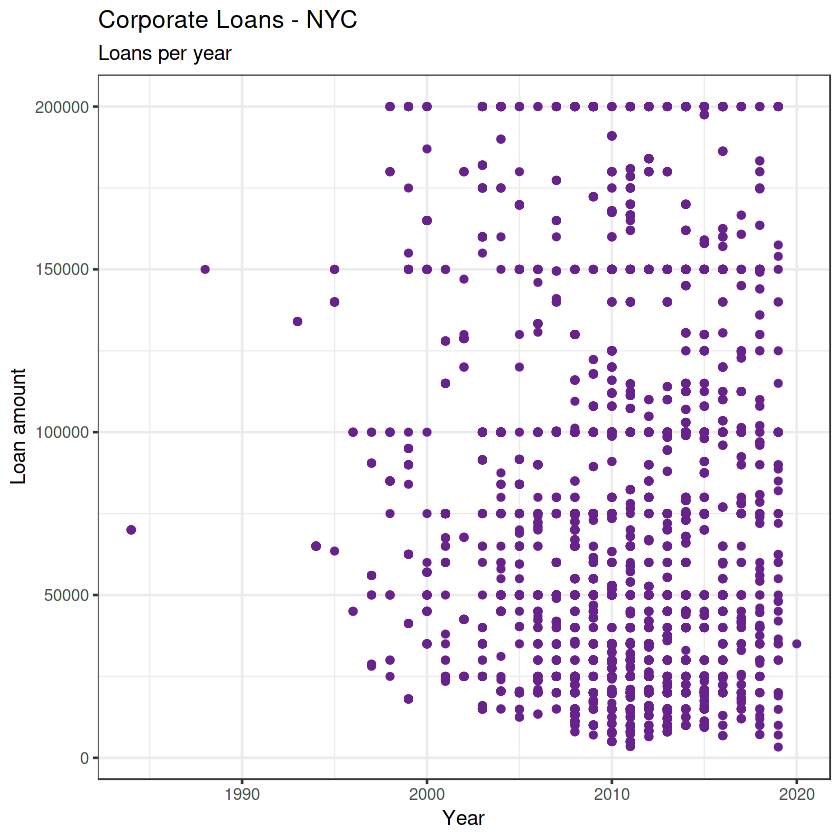

In [9]:
df %>%
  filter(original.loan.amount<=200000) %>%
  ggplot(aes(x = loanaward_year, y = original.loan.amount)) +
  geom_point(color = "darkorchid4") +
  labs(title = "Corporate Loans - NYC",
       subtitle = "Loans per year",
       y = "Loan amount",
       x = "Year") + theme_bw(base_size = 12)

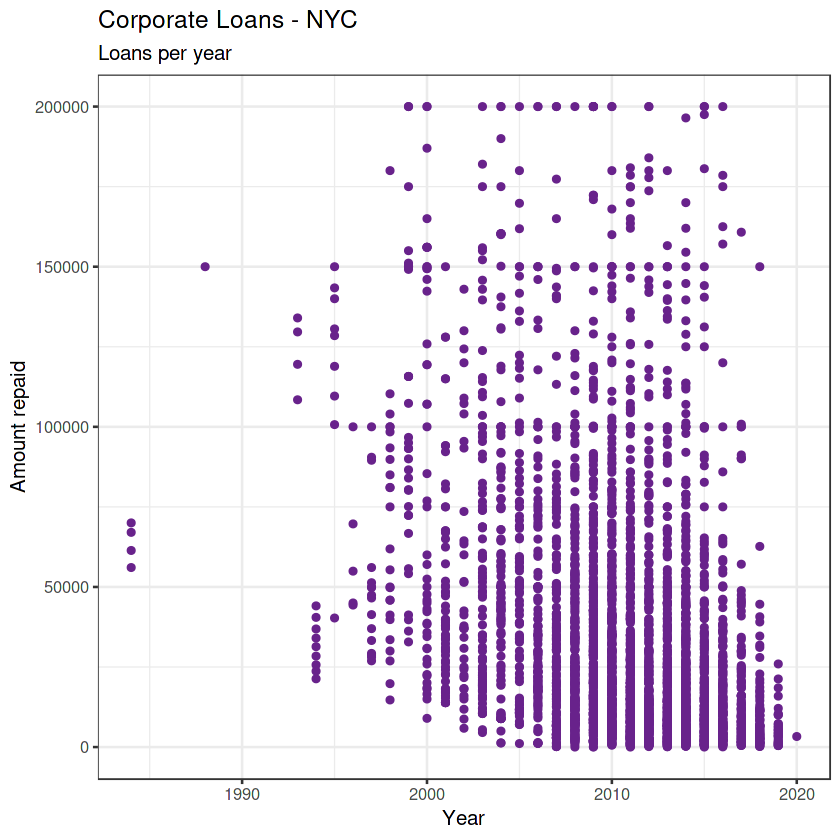

In [10]:
df %>%
  filter(original.loan.amount<=200000 & amount.repaid>0) %>%
  ggplot(aes(x = loanaward_year, y = amount.repaid)) +
  geom_point(color = "darkorchid4") +
  #facet_wrap(~loanaward_year)+
  labs(title = "Corporate Loans - NYC",
       subtitle = "Loans per year",
       y = "Amount repaid",
       x = "Year") + theme_bw(base_size = 12)

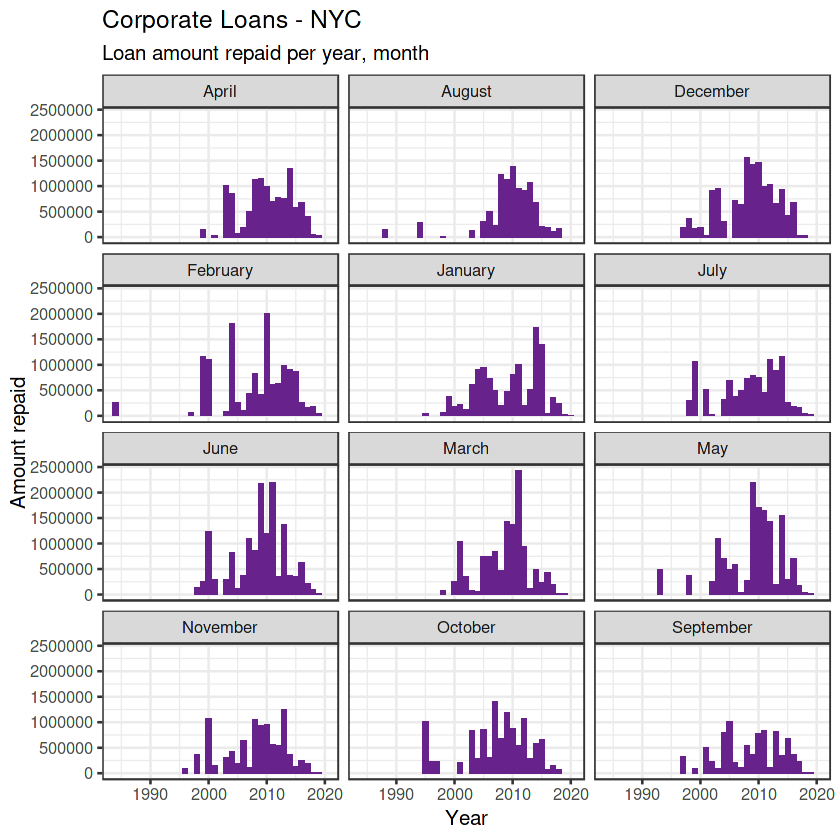

In [11]:
df %>%
  filter(original.loan.amount<=200000 & amount.repaid>0) %>%
  ggplot(aes(x = loanaward_year, y = amount.repaid)) +
  geom_bar(stat = "identity", fill = "darkorchid4") +
  facet_wrap( ~ loanaward_month, ncol = 3) +
  labs(title = "Corporate Loans - NYC",
       subtitle = "Loan amount repaid per year, month",
       y = "Amount repaid",
       x = "Year") + theme_bw(base_size = 12)

#### More will come in time... Work in progress!